# Loading original dataset

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
from sklearn.preprocessing import RobustScaler
from mpl_toolkits.mplot3d import axes3d
# Will allow us to embed images in the notebook
%matplotlib inline

r = 666
np.random.seed(r)

import pandas as pd
dataset = pd.read_csv("../common/dataset.csv", header=0, index_col='CUST_COD')
print(dataset.shape)
# Backup original dataset
orig_dataset = dataset
dataset.head(5)

(26884, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,BIRTH_DATE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,1490.680,M,university,single,NaN,0,0,0,0,2,...,629.156401,599.283174,608.257067,89.440800,149.06800,68.571280,0.000000,29.81360,59.627200,0
35524089,5664.584,M,university,married,04/01/1983,0,0,0,0,0,...,533.872135,-2.772665,-14.399969,149.068000,159.83071,29.813600,0.000000,0.00000,0.000000,1
58777007,6260.856,F,high school,married,02/01/1975,0,0,-1,-1,-2,...,-19.349026,-19.349026,-19.349026,59.627200,532.59015,16.963938,0.000000,0.00000,29.813600,0
26913418,8944.080,F,graduate school,married,15/01/1977,-2,-2,-2,-2,-2,...,88.546392,70.330282,253.177091,80.556347,217.22189,88.784901,70.628418,298.46395,216.416922,0
41993633,3577.632,F,graduate school,married,09/01/1978,-1,-1,-1,-1,-1,...,0.000000,569.439760,0.000000,119.254400,29.81360,0.000000,569.439760,0.00000,0.000000,1


# Different datasets management
- split_and_add
- add_dataset
- retrieve_dataset

In [74]:
# Format: {'name' : X_name}
X_dict = {}
# Format: {'name' : y_name}
y_dict = {}
# Format: {'name' : X_test_name}
X_test_dict = {}
# Format: {'name' : y_test_name}
y_test_dict = {}
names = set()

target_col_name = 'DEFAULT PAYMENT JAN'
from sklearn.model_selection import train_test_split
def split_and_add(dataset, name):
    train, test = train_test_split(dataset, test_size=0.33, random_state=r, stratify=dataset[target_col_name])
    X = train.drop([target_col_name], 1)
    y = train[target_col_name].tolist()
    X_test = test.drop([target_col_name], 1)
    y_test = test[target_col_name].tolist()
    add_dataset(X, y, X_test, y_test, name)
    print('Train X shape: {}'.format(X.shape))
    print('Test X shape: {}'.format(X_test.shape))

def add_dataset(X, y, X_test, y_test, name):
    names.add(name)
    X_dict[name] = X
    y_dict[name] = y
    X_test_dict[name] = X_test
    y_test_dict[name] = y_test

def retrieve_dataset(name):
    return (X_dict[name], y_dict[name], X_test_dict[name], y_test_dict[name])

split_and_add(dataset=orig_dataset.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'BIRTH_DATE'], 1), name='orig')

Train X shape: (18012, 19)
Test X shape: (8872, 19)


# Alessandro's dataset
- One hot encoding of SEX
- scores to MARRIAGE and EDUCATION
- BIRTH_DATE transformed to AGE and normalized
- Columns with money values like LIMIT_BAL and BILL_AMT_DEC normalized togheter to mean=0 std=1
- Delay in payments normalized togheter to mean=0 std=1

In [123]:
# Retrieve original dataset
dataset = orig_dataset

print('One hot encoding SEX feature')
# set(dataset["SEX"]) = {nan, 'M', 'F'}
fields = {'SEX'}
for field in fields:
    dataset = pd.get_dummies(dataset[field], prefix=field).join(dataset.drop([field], 1))

print('Scoring EDUCATION and MARRIAGE features')
# Assume other == Nan
# set(dataset["EDUCATION"]) = {nan, 'high school', 'graduate school', 'other', 'university'}
# set(dataset["MARRIAGE"]) = {nan, 'other', 'single', 'married'}
education_dict = { 'other': 0, 'high school': 0.1, 'university': 0.5, 'graduate school': 1}
marriage_dict = {'other': 0, 'single': 0.1, 'married': 1}
dataset['EDUCATION'] = dataset['EDUCATION'].fillna('other').apply(lambda x: education_dict[x])
dataset['MARRIAGE'] = dataset['MARRIAGE'].fillna('other').apply(lambda x: marriage_dict[x])

print('Computing AGE and dropping BIRTH_DATE')
dataset['BIRTH_DATE'] = pd.to_datetime(dataset['BIRTH_DATE'], format='%d/%m/%Y')
from datetime import date
def calculate_age(birth_date):
    today = date.today()
    age = today.year - birth_date.year
    full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
    if not full_year_passed:
        age -= 1
    return age
dataset['AGE'] = dataset['BIRTH_DATE'].apply(lambda x: calculate_age(x))
dataset = dataset.drop(["BIRTH_DATE"], 1)
dataset['AGE'] = dataset['AGE'].fillna(dataset['AGE'].mean())

from sklearn.preprocessing import RobustScaler
fields = ['LIMIT_BAL',
          'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
          'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
print('Normalizing {}'.format(fields))
#print(offset)
# np.cbrt is the only one that works with negative numbers
# using pow with 1/3 or 1/5 etc with negative numbers leads to complex number as results because of
# numerical approximations
# np.cbrt instead apply the direct algorithm to find cubic root, which is well defined for every negative number
dataset[fields] = dataset[fields].apply(lambda x: x.apply(lambda y: np.cbrt(y)))
#print(dataset[fields].head(5))
rs = RobustScaler()
rs.fit(dataset[fields])
dataset[fields] = rs.transform(dataset[fields])

fields = ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
print('Normalizing {}'.format(fields))
rs.fit(dataset[fields])
dataset[fields] = rs.transform(dataset[fields])

print('Normalizing AGE')
rs.fit(dataset['AGE'].values.reshape(-1, 1))
dataset['AGE'] = rs.transform(dataset['AGE'].values.reshape(-1, 1))

print('Dataset prepared')
print(dataset.shape)

split_and_add(dataset=dataset, name='ale')

dataset.head(5)

One hot encoding SEX feature
Scoring EDUCATION and MARRIAGE features
Computing AGE and dropping BIRTH_DATE
Normalizing ['LIMIT_BAL', 'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL', 'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
Normalizing ['PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
Normalizing AGE
Dataset prepared
(26884, 25)
Train X shape: (18012, 24)
Test X shape: (8872, 24)


,SEX_F,SEX_M,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN,AGE
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,0,1,-0.596128,0.5,0.1,0.0,0.0,0.0,0.0,2.0,...,0.037304,0.062201,0.226817,0.581810,0.107552,-1.242265,-0.152191,0.105527,0,0.114474
35524089,0,1,0.219884,0.5,1.0,0.0,0.0,0.0,0.0,0.0,...,-1.237934,-1.296172,0.602427,0.634121,-0.239826,-1.242265,-1.203857,-1.048531,1,-0.076923
58777007,1,0,0.296956,0.1,1.0,0.0,0.0,-1.0,-1.0,-2.0,...,-1.403861,-1.327530,-0.028983,1.758319,-0.425833,-1.242265,-1.203857,-0.132555,0,0.538462
26913418,1,0,0.593509,1.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-0.520618,-0.205178,0.157470,0.879351,0.236415,0.204414,1.062719,0.725018,0,0.384615
41993633,1,0,-0.102777,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.018849,-0.993142,0.430459,-0.342035,-1.325361,1.658605,-1.203857,-1.048531,1,0.307692


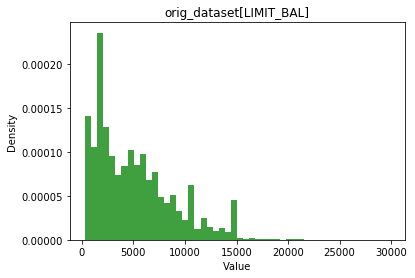

298.136


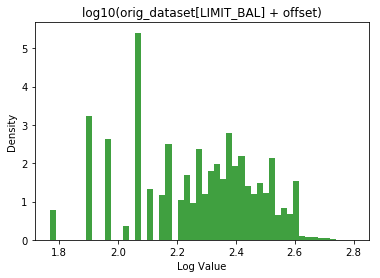

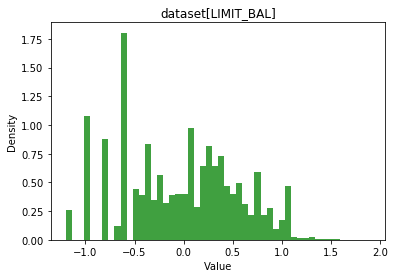

In [124]:
col_name = 'LIMIT_BAL'
# Separare gli 0.
plt.figure(1)
plt.hist(orig_dataset[col_name], 50, normed=1, facecolor='g', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('orig_dataset[{}]'.format(col_name))
plt.show()
plt.figure(1)
print(orig_dataset[col_name].min())
#offset = np.abs(orig_dataset[col_name].min()) + 1e-2
offset = 0
plt.hist(np.power(orig_dataset[col_name] + offset, 1/10), 50, normed=1, facecolor='g', alpha=0.75)
plt.xlabel('Log Value')
plt.ylabel('Density')
plt.title('log10(orig_dataset[{}] + offset)'.format(col_name))
plt.show()
plt.figure(1)
plt.hist(dataset[col_name], 50, normed=1, facecolor='g', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('dataset[{}]'.format(col_name))
plt.show()

# Alessandro's - PCA

Printing PCA with 3 components to visualize dataset


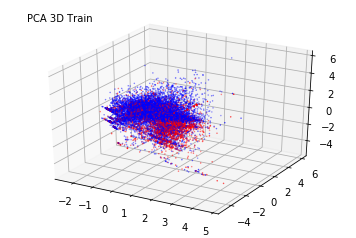

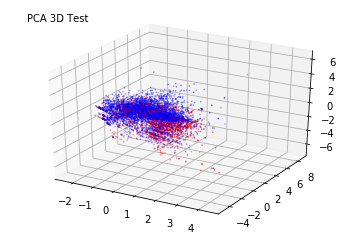

In [127]:
from sklearn.decomposition import PCA
name = 'ale'
X, y, X_test, y_test = retrieve_dataset(name)

print('Printing PCA with 3 components to visualize dataset')
pca = PCA(whiten=True, random_state=r, n_components=3)
pca.fit(X)
colors = {0:'b', 1:'r'}

df = pd.DataFrame(pca.transform(X))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, 'PCA 3D Train', transform=ax.transAxes)
ax.scatter(df[0], df[1], df[2], c=pd.DataFrame(y)[0].apply(lambda x: colors[x]), s=0.25)
plt.show()

df = pd.DataFrame(pca.transform(X_test))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.text2D(0.05, 0.95, 'PCA 3D Test', transform=ax.transAxes)
ax.scatter(df[0], df[1], df[2], c=pd.DataFrame(y_test)[0].apply(lambda x: colors[x]), s=0.25)
plt.show()

Starting PCA
cumsum_tresh = 0.8, n_components = 5
cumsum_tresh = 0.85, n_components = 5
cumsum_tresh = 0.9, n_components = 6
cumsum_tresh = 0.95, n_components = 7
cumsum_tresh = 0.97, n_components = 8
cumsum_tresh = 0.99, n_components = 13


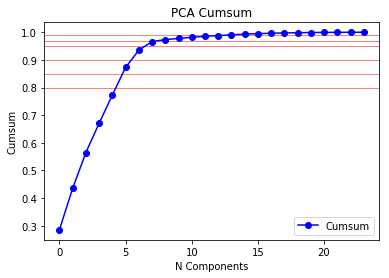

Selecting tresh = 0.97


In [350]:
pca_enabled = True
name = 'ale'
X, y, X_test, y_test = retrieve_dataset(name)
if pca_enabled:
    print('Starting PCA')
    
    pca = PCA(whiten=True, random_state=r)
    pca.fit(X)
    cumsum = pca.explained_variance_ratio_.cumsum()
    cumsum = sorted(list(cumsum))
 
    def find_cumsum_tresh(cumsum, cumsum_tresh):
        for i in np.arange(0, len(cumsum)):
            if cumsum[i] >= cumsum_tresh:
                break
        return i
    
    plt.figure(1)
    # plt.grid(color='k', linestyle='-', linewidth=0.5)
    plt.plot(cumsum, label='Cumsum', marker='o', color='b')
    plt.xlabel('N Components')
    plt.ylabel('Cumsum')
    plt.title('PCA Cumsum')
    plt.legend(loc='best')
    
    for i in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
        n_components = find_cumsum_tresh(cumsum, i)
        print('cumsum_tresh = {}, n_components = {}'.format(i, n_components))
        plt.axhline(y=i, c='red', linewidth=0.5, zorder=0)

    plt.show()
    
    tresh = 0.97
    print('Selecting tresh = {}'.format(tresh))
    n_components = find_cumsum_tresh(cumsum, tresh)
    pca = PCA(whiten=True, random_state=r, n_components=n_components)
    pca.fit(X)
    X_pca = pca.transform(X)
    X_pca_test = pca.transform(X_test)

add_dataset(X_pca, y, X_pca_test, y_test, name+'_pca')

# Models

In [341]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, confusion_matrix, f1_score

cv=StratifiedKFold(n_splits=10, random_state=r, shuffle=True)

def cost_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    # first index true
    # second index predicted
    return cm[0][0] * 0 + cm[0][1] * 1 + cm[1][0] * 5 + cm[1][1] * 0

ms = make_scorer(cost_matrix, greater_is_better=False)

def cv_clf(clf, X, y, X_test, y_test):
    y_pred = clf.predict(X)
    y_pred_test = clf.predict(X_test)
    scores_stkfold = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    f1_cv_mean = scores_stkfold.mean()
    f1_cv_std = scores_stkfold.std()
    f1_train = f1_score(y, y_pred)  
    f1_test = f1_score(y_test, y_pred_test)
    print('f1_train = {:.3f}\t f1_cv = {:.3f} ± {:.3f}\nf1_test = {:.3f}'.format(f1_train, f1_cv_mean, f1_cv_std, f1_test))
    # cost_train = cost_matrix(y, y_pred)
    # cost_test = cost_matrix(y_test, y_pred_test)
    # print('cost_train = {}\ncost_test = {}'.format(format(cost_train, ','), format(cost_test, ',')))
    cm_train = confusion_matrix(y, y_pred)
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('cm_train = \n{}\ncm_test = \n{}'.format(cm_train, cm_test))

def fit_and_score(clf, name):
    print('Evaluating on ' + name + ' dataset')
    X, y, X_test, y_test = retrieve_dataset(name)
    clf.fit(X, y)
    cv_clf(clf, X, y, X_test, y_test)    
    
print('Defined functions')

Defined functions


In [351]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier(random_state=r)
fit_and_score(clf, 'ale')
fit_and_score(clf, 'orig')

Evaluating on ale dataset
f1_train = 0.221	 f1_cv = 0.217 ± 0.018
f1_test = 0.225
cm_train = 
[[10932  3098]
 [ 3104   878]]
cm_test = 
[[5369 1541]
 [1519  443]]
Evaluating on orig dataset
f1_train = 0.221	 f1_cv = 0.217 ± 0.018
f1_test = 0.225
cm_train = 
[[10932  3098]
 [ 3104   878]]
cm_test = 
[[5369 1541]
 [1519  443]]


In [226]:
from sklearn import svm
clf = svm.SVC(random_state=r, C=1, class_weight='balanced')
fit_and_score(clf, 'ale')
fit_and_score(clf, 'ale_pca')

Evaluating on ale dataset


KeyboardInterrupt: 

In [354]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=r, max_depth=4, class_weight='balanced')
fit_and_score(clf, 'ale')
fit_and_score(clf, 'orig')

Evaluating on ale dataset
f1_train = 0.534	 f1_cv = 0.533 ± 0.021
f1_test = 0.527
cm_train = 
[[11562  2468]
 [ 1631  2351]]
cm_test = 
[[5701 1209]
 [ 828 1134]]
Evaluating on orig dataset
f1_train = 0.534	 f1_cv = 0.533 ± 0.021
f1_test = 0.527
cm_train = 
[[11562  2468]
 [ 1631  2351]]
cm_test = 
[[5701 1209]
 [ 828 1134]]


In [368]:
from sklearn.naive_bayes import GaussianNB
# No random_state
# The priors are set based on class distribution in the dataset
# No CV needed
clf = GaussianNB()
fit_and_score(clf, 'ale')
fit_and_score(clf, 'ale_pca')
fit_and_score(clf, 'orig')

Evaluating on ale dataset
f1_train = 0.520	 f1_cv = 0.515 ± 0.012
f1_test = 0.525
cm_train = 
[[11484  2546]
 [ 1687  2295]]
cm_test = 
[[5666 1244]
 [ 822 1140]]
Evaluating on ale_pca dataset
f1_train = 0.396	 f1_cv = 0.390 ± 0.009
f1_test = 0.395
cm_train = 
[[6394 7636]
 [1117 2865]]
cm_test = 
[[3177 3733]
 [ 560 1402]]
Evaluating on orig dataset
f1_train = 0.521	 f1_cv = 0.516 ± 0.011
f1_test = 0.528
cm_train = 
[[11529  2501]
 [ 1700  2282]]
cm_test = 
[[5687 1223]
 [ 821 1141]]


In [51]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=r, n_estimators=67, class_weight='balanced', n_jobs=-1)
fit_and_score(clf, 'ale')
fit_and_score(clf, 'ale_pca')

f1_train = 0.999	 f1_cv = 0.460 ± 0.018
f1_test = 0.445
cost_train = 32
cost_test = 6,827
cm_train = 
[[14028     2]
 [    6  3976]]
cm_test = 
[[6498  412]
 [1283  679]]


In [52]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=19, weights='distance', n_jobs=-1)
fit_and_score(clf, 'ale')
fit_and_score(clf, 'ale_pca')

f1_train = 0.999	 f1_cv = 0.454 ± 0.027
f1_test = 0.429
cost_train = 30
cost_test = 6,986
cm_train = 
[[14030     0]
 [    6  3976]]
cm_test = 
[[6509  401]
 [1317  645]]


In [203]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(10,7,5,3), random_state=r)
fit_and_score(clf, 'ale')
#fit_and_score(clf, 'ale_pca')

Evaluating on ale dataset
f1_train = 0.470	 f1_cv = 0.467 ± 0.026
f1_test = 0.430
cm_train = 
[[13486   544]
 [ 2593  1389]]
cm_test = 
[[6586  324]
 [1336  626]]


Evaluating on ale dataset
f1_train = 0.473	 f1_cv = 0.469 ± 0.013
f1_test = 0.476
cm_train = 
[[9863 4167]
 [1457 2525]]
cm_test = 
[[4926 1984]
 [ 730 1232]]
Evaluating on orig dataset
f1_train = 0.514	 f1_cv = 0.512 ± 0.018
f1_test = 0.509
cm_train = 
[[12086  1944]
 [ 1933  2049]]
cm_test = 
[[5972  938]
 [ 972  990]]
[[ -1.51185659e-05   3.92566146e-01   4.36418883e-02   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00  -9.22595948e-05
    2.27742942e-05   5.20021426e-05   1.44996378e-05   1.32368458e-05
    2.36288112e-05  -3.02185678e-04  -3.18049841e-04  -1.29279891e-04
   -1.47709297e-04  -1.72766604e-04   1.19958023e-05]]


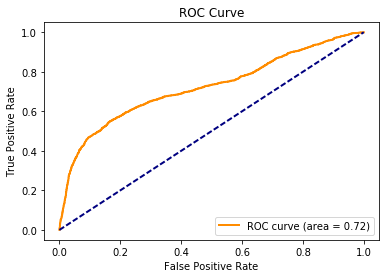

In [367]:
from sklearn.linear_model import LogisticRegression
# l1 0.01 balanced f1_test = 0.485282
# l2 0.01 balanced f1_test = 0.483491

# l1 0.001 orig f1 = 0.511950840163
# l2 0.0001 orig f1 = 0.501479445524

clf = LogisticRegression(penalty='l1', C=0.001, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
fit_and_score(clf, 'ale')
fit_and_score(clf, 'orig')

from sklearn.metrics import roc_curve, auc

X, y, X_test, y_test = retrieve_dataset('orig')
clf.fit(X, y)
print(clf.coef_)

y_score = clf.decision_function(X_test)
# Compute ROC curve and ROC area for each class
fpr, tpr, t = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# t_sigm = 1 / (1 + np.exp(-t))

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [372]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

cv=StratifiedKFold(n_splits=5, random_state=r, shuffle=True)

#parameters = {'C': [1e-10, 1e-7, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
#clf = LogisticRegression(penalty='l2', class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=1)

parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = DecisionTreeClassifier(random_state=r, class_weight='balanced')

#parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
#clf = svm.SVC(random_state=random_state, class_weight='balanced')

#parameters = {'n_estimators': np.arange(1,100)}
#clf = RandomForestClassifier(random_state=random_state, class_weight='balanced')

#parameters = {'priors': [[0.1, 0.9], [0.2, 0.8], [0.5, 0.5], [0.8, 0.2], [0.9, 0.1]]}
#clf = GaussianNB()

#parameters = {'hidden_layer_sizes': np.arange(2,100)}
#clf = MLPClassifier(random_state=random_state)

dataset_name = 'ale'
scoring_name = 'f1'
n_jobs = -1
if scoring_name == ms:
    n_jobs = 1
gscv = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=n_jobs, cv=cv, scoring=scoring_name)
X, y, X_test, y_test = retrieve_dataset(dataset_name)
gscv.fit(X, y)
print('GridSearchCV done on dataset ' + dataset_name)
print(gscv.best_params_)
print(scoring_name + ' = ' + str(gscv.best_score_))

GridSearchCV done on dataset ale
{'max_depth': 4}
f1 = 0.53285247868


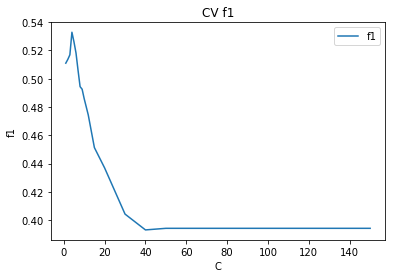

In [373]:
plt.figure(1)
if scoring_name == ms:
    scoring_name = 'Cost'
#plt.plot([prior[0] for prior in parameters['priors']], gscv.cv_results_['mean_test_score'], label=scoring_name)
#plt.plot(parameters['n_estimators'], gscv.cv_results_['mean_test_score'], label=scoring_name)
#plt.plot(parameters['C'], gscv.cv_results_['mean_test_score'], label=scoring_name)
#plt.semilogx(parameters['C'], gscv.cv_results_['mean_test_score'], label=scoring_name, marker='o', color='b')
plt.plot(parameters['max_depth'], gscv.cv_results_['mean_test_score'], label=scoring_name)
#plt.plot(parameters['hidden_layer_sizes'], gscv.cv_results_['mean_test_score'], label=scoring_name)
plt.xlabel('C')
plt.ylabel(scoring_name)
plt.title('CV ' + scoring_name)
plt.legend(loc='best')
plt.show()

In [ ]:
target = pd.read_csv("./common/target.csv")
target = target.drop([target_col_name], 1)
target_nan = target[pd.isnull(target).any(axis=1)]